In [1]:
from score_models import ScoreModel
import torch 
import numpy as np 
import matplotlib.pyplot as plt
from torch.func import vmap, grad 
from tqdm import tqdm
import sys
sys.path.append("../models/")
from gridding import ft, ift 
from posterior_sampling import *
plt.style.use("dark_background")

device  = "cuda" if torch.cuda.is_available() else "cpu"

def probes_link_function(x):
    return link_function(x, C=1/2, B=1/2)

In [2]:
# Loading the weights for a score model trained on a prior: 
score_model = ScoreModel(checkpoints_directory = "../../score_models/ncsnpp_probes_g_64_230604024652/")

Using the Variance Exploding SDE


In [3]:
data_path = "../../../data/"
prior_samples = torch.load(data_path + "probes_prior_samples.pt")
sampling_function = torch.tensor(np.load(data_path + "\data_htlup\sampling_function3.npy"))[:256**2]

S = sampling_function.reshape(256, 256).to(device)

In [4]:
sample = prior_samples[0, 0]
padded_sample = torch.nn.functional.pad(prior_samples[0,0], [96, 96, 96, 96])

In [5]:
def dirty_imager(x, sampling_function): 
    dirty_image = ift(ft(x) * sampling_function.to(torch.uint8))
    return dirty_image.real

def padding(x, pad): 
    H, W = x.shape
    return torch.nn.functional.pad(x, [pad, pad, pad, pad])

def unpadding(x, pad):
    H, W = x.shape
    full_img = x.shape[-1]
    img_size = full_img - 2* pad
    T = (full_img+ img_size)//2 
    D = (full_img-img_size)//2 
    L = (full_img-img_size)//2 
    R = (full_img+ img_size)//2  
    return x[D:T,L:R].reshape(img_size, img_size)


Text(0.5, 1.0, 'Dirty image')

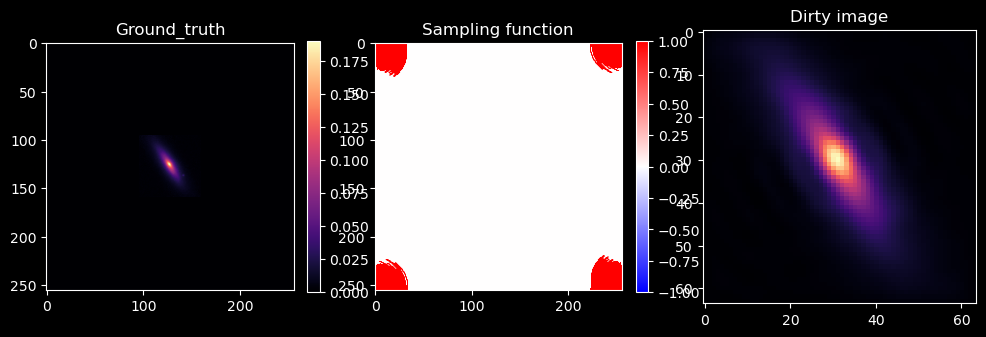

In [6]:
fig, axs = plt.subplots(1, 3, figsize = (3*4, 4))

padded_sample = padding(probes_link_function(prior_samples[0,0]), pad = 96)
im = axs[0].imshow(padded_sample.cpu().numpy(), cmap = "magma")
axs[0].set_title("Ground_truth")
plt.colorbar(im, ax = axs[0], fraction = 0.046)

im = axs[1].imshow(S.squeeze().cpu(), cmap = "bwr", vmin = -1)
plt.colorbar(im, ax = axs[1], fraction = 0.046)
axs[1].set_title("Sampling function")

dirty_image = dirty_imager(padded_sample, S)
dirty_image = unpadding(dirty_image, pad = 96)
axs[2].imshow(dirty_image.squeeze().cpu().numpy(), cmap = "magma")
axs[2].set_title("Dirty image")

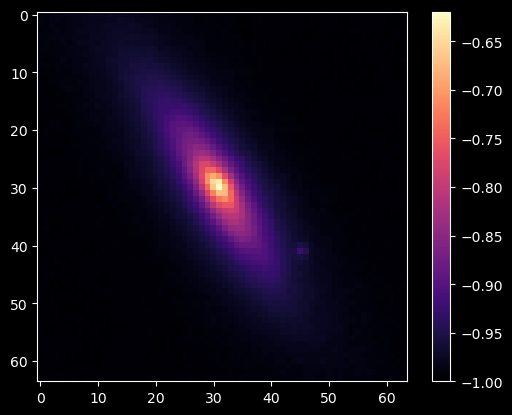

In [7]:
x = prior_samples[0]
plt.imshow(x.squeeze().cpu(), cmap = "magma")
plt.colorbar()

In [8]:
# Creating a fake observation
pad =  96 # 64 + 2 * 96 = 256 (sampling function for htlup is 256*256)

def noise_padding(x, pad, sigma):
    _, H, W = x.shape
    out = torch.nn.functional.pad(x, (pad, pad, pad, pad)) 
    # Create a mask for padding region
    mask = torch.ones_like(out)
    mask[pad:pad + H, pad:pad+W] = 0.
    
    # Noise pad around the model
    z = torch.randn_like(out) * sigma
    out = out + z * mask
    return out

def model(t, x): 
    x = probes_link_function(x)    
    x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(x_padded).squeeze()[S]
    return complex_to_real(vis_sampled)

def model_to_plot(t, x):
    x = probes_link_function(x)    
    x_padded = noise_padding(x, pad = pad, sigma = sigma(t, score_model))
    vis_sampled = ft(x_padded) * S.to(torch.uint8)
    return complex_to_real(vis_sampled)


In [18]:
t = torch.zeros(size = (1,1)).to(device)


x = prior_samples[0]
# Creating an observation
sigma_y = 1e-4
y = model(t, x)
y += sigma_y * torch.randn_like(y)

Text(0.5, 1.0, 'Dirty image')

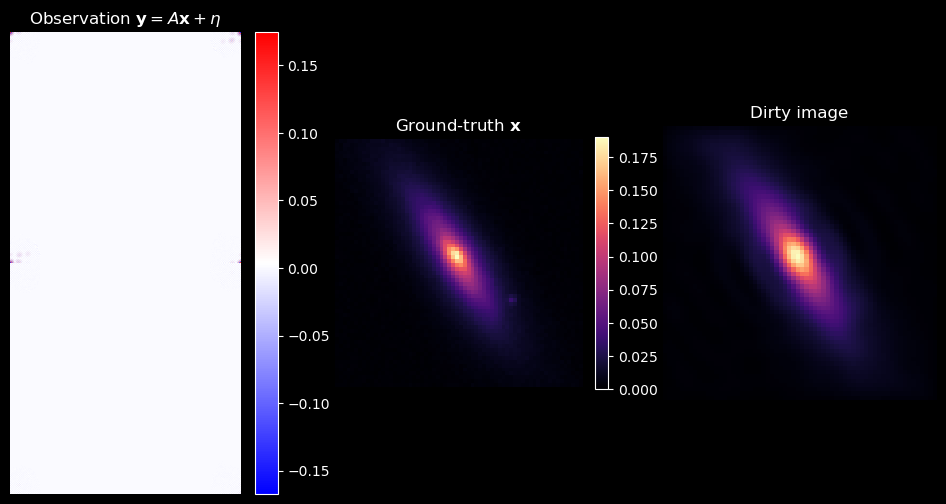

In [20]:
y_to_plot = model_to_plot(t, x)
dirty_image = unpadding(ift(real_to_complex(y_to_plot.squeeze())).real, pad = 96)

# Verifying we don't do weird stuff
n_cols = 3
fig, axs = plt.subplots(1, n_cols, figsize = (n_cols * 4, 6))

for i in range(n_cols): 
    axs[i].axis("off")

im = axs[0].imshow(y_to_plot.reshape(-1,256).cpu(), cmap = "bwr")
axs[0].set_title(r"Observation $\mathbf{y} = A\mathbf{x} +\eta$")
plt.colorbar(im, fraction = 2 * 0.046)
im = axs[1].imshow(probes_link_function(x).squeeze().cpu(), cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

im = axs[2].imshow(dirty_image.squeeze().cpu(), cmap = "magma")
axs[2].set_title("Dirty image")

In [71]:
real_to_complex(y_to_plot).shape

torch.Size([1, 256])

In [77]:
S = sampling_function.reshape(256, 256).to(device)

In [46]:
S.shape

torch.Size([1, 1, 256, 256])

In [54]:
def log_likelihood(y, x, t, sigma_y, forward_model):
    y_hat = forward_model(t, x) # model prediction
    var = sigma(t, score_model) ** 2/2 + mu(t, score_model)**2 * sigma_y ** 2
    var_0 = sigma(t, score_model) ** 2 + mu(t, score_model)**2 * sigma_y ** 2

    diff = (y_hat - mu(t, score_model) * y)**2
    res = diff/var
    res[0] = diff[0]/var_0
    log_prob = - 0.5 * torch.sum(res)
    return log_prob

def score_likelihood(y, x, t, sigma_y, forward_model): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y, forward_model)), randomness = "different")(x, t)

In [55]:
t = torch.ones(size = (1, 1)).to(device)
x = torch.randn(size = (1, 1, 64, 64)).to(device)
score_likelihood(y, x, t, sigma_y, forward_model=model).shape

torch.Size([1, 1, 64, 64])

In [56]:
t = torch.ones(size = (1, 1)).to(device)
x = torch.randn(size = (1, 64, 64)).to(device)

log_likelihood(y, x, t, sigma_y, forward_model=model)

tensor(-1877.1295, device='cuda:0')

In [61]:
samples = euler_sampler(
    y = y,
    sigma_y = sigma_y,
    forward_model = model, 
    score_prior = score_model, 
    score_likelihood = score_likelihood, 
    num_samples = 4, 
    num_steps = 500, 
    img_size = (64, 64)
)

t = 0.00 | scale ~ 3.74e-02 | sigma(t) = 1.05e-03 | mu(t) = 1.00e+00: 100%|██████████| 499/499 [01:07<00:00,  7.44it/s]


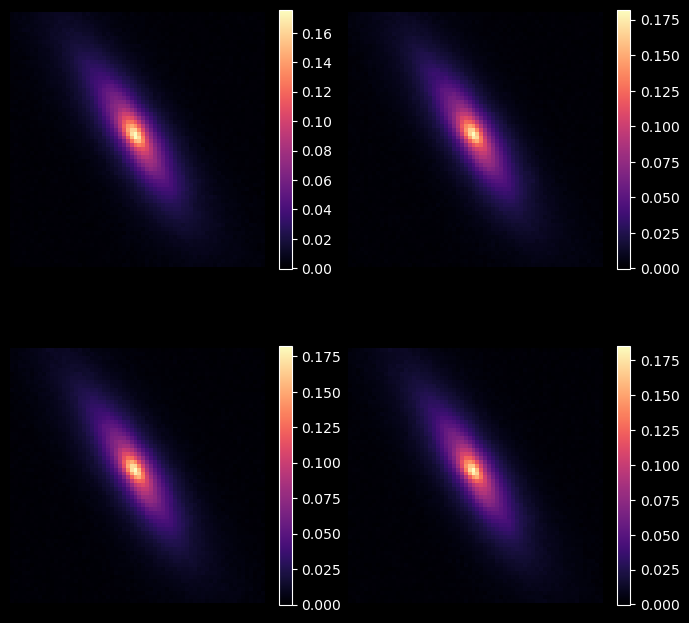

In [67]:
fig, axs = plt.subplots(2, 2, figsize = (4*2, 4*2))


k = 0
for i in range(2): 
    for j in range(2):
        im = axs[i, j].imshow(probes_link_function(samples[k]).squeeze().cpu(), cmap = "magma")
        plt.colorbar(im, fraction = 0.046)
        axs[i,j].axis("off")
        k+=1


(-0.5, 63.5, 63.5, -0.5)

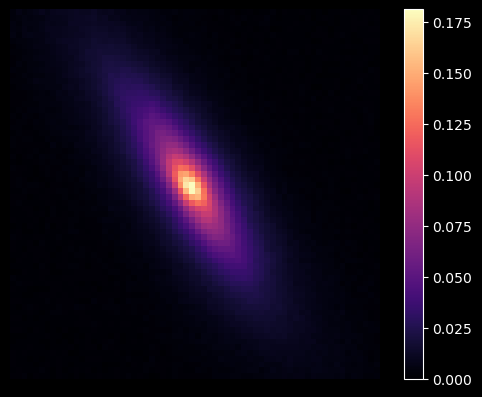

In [60]:
plt.imshow(probes_link_function(samples.squeeze()).cpu(), cmap = "magma")
plt.colorbar()
plt.axis("off")

## Creating an observation and reconstructing the associated ground-truth 

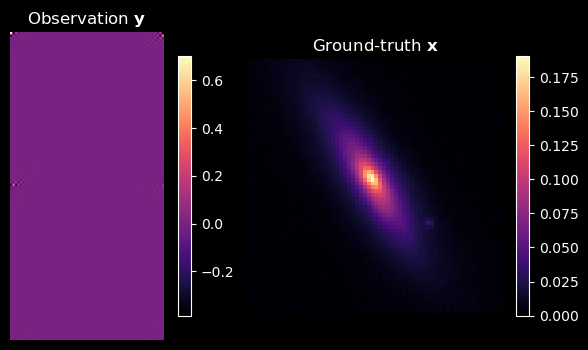

In [94]:

# Creating the observation
sigma_y = 1e-3

# Picking a ground-truth (let's take the most beautiful galaxy)
img_size = prior_samples.shape[-1]
x = probes_link_function(prior_samples[0, 0])
y_complex = complex_to_real(ft(x))

# Real representation
y = y_complex + sigma_y * torch.randn_like(y_complex.real, device = x.device)


# Plot it to see:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

im = axs[0].imshow(y.reshape(-1, img_size).squeeze().cpu(), cmap = "magma")
plt.colorbar(im, fraction = 0.046)
axs[0].set_title(r"Observation $\mathbf{y}$")

im = axs[1].imshow(x.reshape(img_size, img_size).squeeze().cpu(), cmap = "magma")
axs[1].set_title(r"Ground-truth $\mathbf{x}$")
plt.colorbar(im, fraction = 0.046)

In [93]:
torch.randn_like(y_complex.real, device = x.device).shape

torch.Size([64, 64])

In [91]:
y.shape

torch.Size([128, 64])

In [27]:
torch.randn_like(y_complex)

tensor([[[-0.8821+0.2133j,  0.2963+0.2806j, -1.5133+0.0584j,  ...,
           0.2818+1.7443j,  0.5406+0.2781j, -1.0672+0.3773j],
         [ 1.9743+0.3312j,  1.0889+0.1976j,  1.7837-0.1736j,  ...,
           0.2578+1.1343j,  0.1919-0.8562j,  0.1203-0.3024j],
         [ 0.5600-1.0036j, -0.0478+0.4545j, -0.7606-0.4640j,  ...,
          -0.4196+0.8270j, -0.0021-0.7913j, -0.8718+0.9636j],
         ...,
         [-0.1533+0.3594j,  0.1452-0.4082j, -0.2950+0.0780j,  ...,
          -0.5305-0.1444j,  0.6622+0.2589j, -0.1294-1.3370j],
         [ 1.0445+0.0800j,  0.5746+0.9066j, -0.6117-1.0140j,  ...,
           0.2151+0.6265j,  0.3645-0.3487j,  0.8503+0.2620j],
         [ 0.7605-0.1538j,  0.5910+0.4180j, -0.7129-0.3297j,  ...,
           0.4719+0.1283j,  0.5713+0.0860j,  1.2804+0.9451j]]],
       device='cuda:0')

In [101]:
def model(t, x): 
    x = probes_link_function(x)
    y_hat = complex_to_real(ft(x))
    return y_hat

def log_likelihood(y, x, t, sigma_y, forward_model):
    y_hat = forward_model(t, x) # model prediction
    var = sigma(t, score_model) ** 2 + mu(t, score_model)**2 * sigma_y ** 2 
    log_prob = - 0.5 * torch.sum((y_hat - mu(t, score_model) * y)**2/var)
    return log_prob

def score_likelihood(y, x, t, sigma_y, forward_model): 
    return vmap(grad(lambda x, t: log_likelihood(y, x, t, sigma_y, forward_model)), randomness = "different")(x, t)

In [104]:
samples = euler_sampler(
    y = y,
    sigma_y = sigma_y,
    forward_model = model, 
    score_prior = score_model, 
    score_likelihood = score_likelihood, 
    num_samples = 1, 
    num_steps = 500, 
    img_size = (64, 64)
)

t = 0.00 | scale ~ 3.64e-02 | sigma(t) = 1.05e-03 | mu(t) = 1.00e+00: 100%|██████████| 499/499 [00:22<00:00, 22.28it/s]


(-0.5, 63.5, 63.5, -0.5)

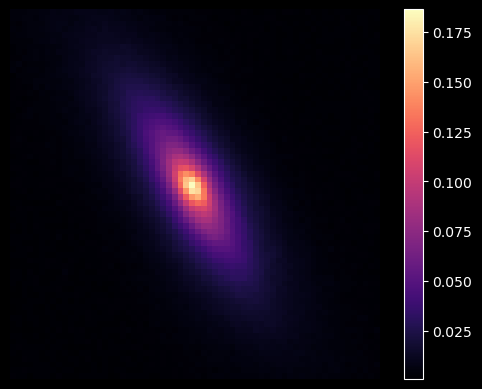

In [105]:
plt.imshow(probes_link_function(samples.squeeze()).cpu(), cmap = "magma")
plt.colorbar()
plt.axis("off")